In [3]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
%matplotlib inline

## Create necessary classes and functions

In [4]:
xl=pd.ExcelFile('./data/CA_TSP.xlsx')
print(xl.sheet_names)
cities = xl.parse('city_ridership')
cities_dist_matrix = xl.parse('city_dist_matrix')


['city_ridership', 'city_dist_matrix']


Create class to handle "cities"

In [5]:
class City:
    def __init__(self,name,population,has_petrol):
        self.name=name
        self.population=population
        self.has_petrol=has_petrol
    
    def distance(self, city):
        distance=cities_dist_matrix.loc[self.name,city.name]
        return distance
    
    def __repr__(self):
        return self.name+"["+str(self.population)+"]"

Create a fitness function

In [6]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
        self.total_population= 0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    break
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routePopulation(self):
        if self.total_population ==0:
            path_population = 0
            for i in range(0, len(self.route)):
                City = self.route[i]
                path_population += fromCity.population
            self.total_population = path_population
        return self.total_population
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

In [7]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [8]:
def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Create the genetic algorithm

Rank individuals

In [9]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [10]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [11]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [12]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [13]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [14]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [15]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [16]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [17]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

Create list of cities

In [18]:
cityList = []
len(cities.City)
for i in range(0,len(cities.City)):
    cityList.append(City(name=cities.City.iloc[i],population=cities.Population.iloc[i],\
                        has_petrol=cities.Has_petrol.iloc[i]))


Run the genetic algorithm

In [19]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 1092.0
Final distance: 389.0


[A[33],
 Y[24],
 M[14],
 Q[49],
 W[26],
 D[39],
 L[31],
 K[13],
 G[17],
 O[25],
 F[17],
 C[13],
 E[43],
 V[26],
 I[13],
 U[37],
 S[25],
 X[45],
 J[22],
 N[46],
 P[17],
 H[20],
 T[45],
 R[33],
 B[15]]

## Plot the progress

Note, this will win run a separate GA

In [20]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

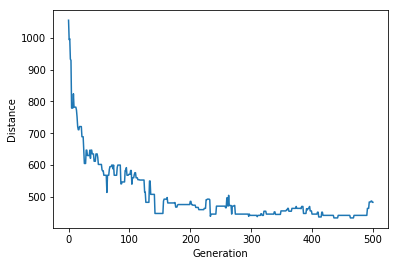

In [21]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)